# **INTRODUCTION**
This notebook was developed by 4 members namely Mohanteja, Suhan, vignesh and Vivek which explains the code for the models we developed to summarize medical report of a patient and also compare's the results of the various models we used with rouge metric and explains which model is predicting good summaries with good rouge score and why.

**TEXT SUMMARIZATION:**
Using Deep Learning, we can implement tasks belongs NLP or Computer Vision became easy by using various neural netwok algorithms. Text summarization is a task of reducing the length of big article, book, report, etc., and gives a brief explanation in few sentences without loosing the meaning of original context.

**NEURAL NETWORK:**
computer network which try to mimic human brain and try to perform activities like human brain using numerous artificial neurons are called neural networks, there are 3 types of neural networks,
1. Convolutional neural networks
2. Recurssive Neural Networks
3. Transformers.

**Convolutional neural networks (CNN):**
    the idea of having sliding window that reduces things down to fewer dimensions. It is good for images and videos but not so much for language data i.e., NLP tasks.

**Recursive Neural Networks (RNN):**
    same as CNN will have sliding windows that moves along an input sequence. main advantage of RNN over CNN is it could remember the data from previous few sequence of data from previous neurons. Its good with sequence data and had few successful applications in NLP tasks but limits to how much we can parallelize training

**Transformers:**
    Transformers is very new concept in neural network which was introduced in the year 2017. Unlike CNN and RNN, transformers can train the model with entire data as an input in one go. the tasks with transformers can be higly parallelized and the results of NLP tasks are pretty good compared to RNN.
    
# We used 2 RNN models LSTM and GRU to develop our model from scratch and also used few state of the art pretrained models to predict and compare the results with the results we got from our models. The state of the art models that we used are developed based on transformers and the pretrained models we used are BART, PEGASUS, T5 and used them to compare our results with LSTM, GRU models that were developed by us from scratch and trained on the medical dataset we choose. We couldn't be able to implement BERT model for summaries bacause, BERT is masked word bidirectional encoder which is suitable for text completion or language translation but for text summarization, it is not suitable. We also fine tuned t5 model and BART model with our medical dataset to check weather it is predicting good summaries then pretrained model.


---

# **MOTIVATION**
The motivation behind choosing text summarization of patient's medical reports is that there so many medical reports of so many people and it is very time consuming to go through the complete report to find the correct problem the patient is suffering from. So, if there is small brief explaination of the entire report of the patient, then it will become easy for doctors or even for normal people to easily understand what patient is suffering from and what needs to be done to cure it, in less amount of time. So, that's the reason why we choose the project of summarizing the patient's medical report.


---


# **PROBLEM STATEMENNT**
The main purpose of our project is to summarize the long medical reports of a patint. A medical report of a patient might be very long and could be many pages and going through the complete report for doctors to find out what patient is suffering from might be very time consuming. So, we thought of summarizing that whole report and give the brief explanation on what the patient is suffering from which will reduce so much time for doctors from reading the entire medical report.

# **Data Sources**
We have researched and searched for the right dataset for our project which help us to train our model to summarize the medical reports of patients.
In the process of our research, we came accross a dataset which contains transcriptions of the patients along with its descrition which is like a summary of the transcrition along with that it also contain fiels like keywords, medical_speciality, sample_names, etc., which will help us to refine and pre process it to our convinience which will give us good accuracy of summary along with good rouge metric.

The Dataset we used is https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions 

The entir pre processing steps we did for the above datset were explained in notebook in below cells.

For pretrained models, we can find the dataset they used from their official paper, here are the links for their official paper,

BART -> https://arxiv.org/abs/1910.13461 

T5 -> https://arxiv.org/abs/1910.10683 

PEGASUS -> https://arxiv.org/abs/1912.08777 

# **Importing Required Modules**

In [ ]:
from __future__ import unicode_literals, print_function, division
import numpy as np 
import pandas as pd
import os

import re
from nltk.corpus import stopwords


from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import WhitespaceTokenizer
from nltk import sent_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

In [ ]:
! pip install transformers datasets
! pip install rouge-score nltk
! pip install huggingface_hub

/bin/bash: /home/rkv/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/rkv/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/rkv/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# **DATA PRE PROCESSING and VISUALIZATION STEPS**

**Loading and Cleaning Dataset**

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/mtsamples.csv')

In [ ]:
dataset.drop_duplicates()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


In [ ]:
dataset.shape

(4999, 6)

In [ ]:
dataset.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
dataset.drop("Unnamed: 0", axis = 1, inplace=True)
dataset.drop("keywords", axis = 1, inplace=True)

In [ ]:
#if package not found - run the next line of code
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/rkv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset.dropna(axis = 0, inplace = True)

In [ ]:
def remove_stopwords(text):
    if isinstance(text, str):
        new_text = []
        text = text.split()
        for word in text:
            if word not in stop_words:
                new_text.append(word)
        text = " ".join(new_text)
        return text

In [ ]:
#from a kaggle notebook - will add reference 
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
def lowercase(object):
    if isinstance(object, str):
        object = str.lower(object)
    return object

def contractions(object):
    if isinstance(object, str):
        if object in contraction_mapping:
            temp_word = contraction_mapping[object]
            object = temp_word
    return object

def remove_punctuation(object):
    #leave ":" and "." - section and full stop, respectively. Info about sequences
    #remove "," ; "/" ; " "
    if isinstance(object, str): 
        expression = r"[!\#\$'\*\;%']"
        empty_str = ""
        result = re.sub(expression, empty_str, object, 0, re.MULTILINE)
        return result
    else:
        return object

#flag 1,2,3 - 1 - lowercase, 2 - stopwords, 3 - contraction, 4 - punctuation
def apply_df(df, label, flag):
    if flag == 1:
        df.loc[:, label] = df[label].apply(lambda x : lowercase(x))
    elif flag == 2:
        df.loc[:, label] = df[label].apply(lambda x : remove_stopwords(x))
    elif flag == 3:
        df.loc[:, label] = df[label].apply(lambda x : contractions(x))
    elif flag == 4:
        df.loc[:, label] = df[label].apply(lambda x : remove_punctuation(x))
    return df
dataset = apply_df(dataset, 'transcription', 1)
dataset = apply_df(dataset, 'description', 1)
dataset.head()

,description,medical_specialty,sample_name,transcription
0,a 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female pr..."
1,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climb..."
2,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"history of present illness: , i have seen abc ..."
3,2-d m-mode. doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement wit..."
4,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. the left ventricular cavity size and wall ...


In [ ]:
dataset = apply_df(dataset, 'transcription', 2)
dataset = apply_df(dataset, 'description', 2)
dataset = apply_df(dataset, 'transcription', 3)
dataset = apply_df(dataset, 'description', 3)
dataset = apply_df(dataset, 'transcription', 4)
dataset = apply_df(dataset, 'description', 4)

**Exploratory Data Analysis**

In [ ]:
#refactor
medical_specialties_list = []
trans_word_count_list = []
summary_word_count_list = []
for word in dataset['medical_specialty'].unique():
    medical_specialties_list.append(word)
    dataset_filtered = dataset[(dataset['medical_specialty'] == word)]
    trans_word_count = dataset_filtered['transcription'].str.split().str.len().sum()
    summary_word_count = dataset_filtered['description'].str.split().str.len().sum()
    trans_word_count_list.append(trans_word_count)
    summary_word_count_list.append(summary_word_count)
    
words_df = pd.DataFrame({'specialty': medical_specialties_list, 'text_word_count': trans_word_count_list, 'summary_word_count': summary_word_count_list})
words_df['text_word_count'] = words_df['text_word_count'].astype('int')
words_df['summary_word_count'] = words_df['summary_word_count'].astype('int')
words_df = words_df.sort_values('text_word_count', ascending=False)
words_df = words_df.sort_values('summary_word_count', ascending=False)
words_df.reset_index(drop=True, inplace = True)

In [ ]:
words_df.head()

,specialty,text_word_count,summary_word_count
0,Surgery,311281,15697
1,Consult - History and Phy.,174469,6381
2,Cardiovascular / Pulmonary,100753,5648
3,Orthopedic,118102,5559
4,General Medicine,74040,3091


In [ ]:
#all the different medical_specialty values:
dataset['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

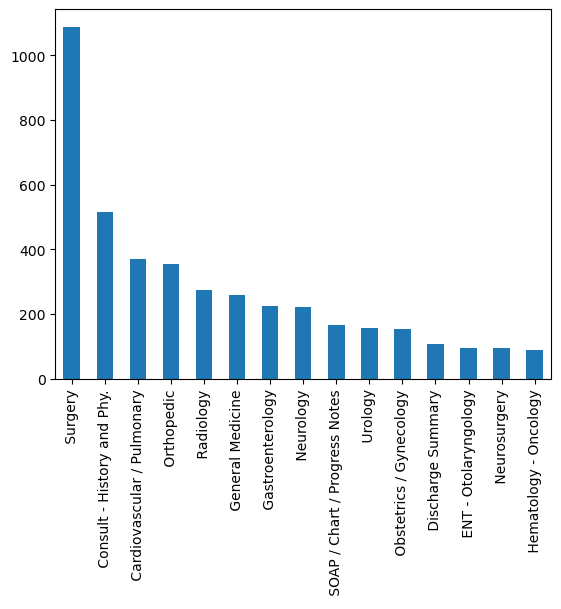

In [ ]:
med_counts = dataset['medical_specialty'].value_counts()
ax = med_counts[:15].plot.bar(y = "Freq")
#frequency distribution of number of records - first 15

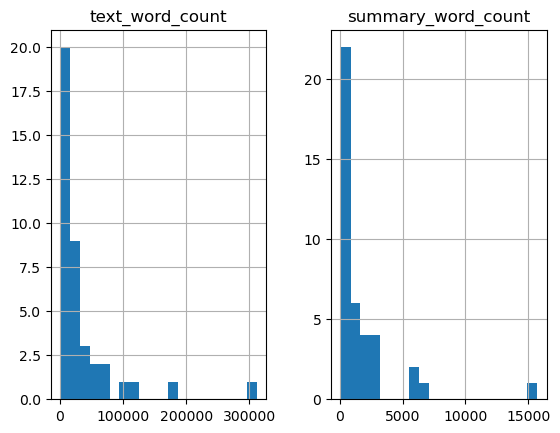

In [ ]:
import matplotlib.pyplot as plt
words_df.hist(bins = 20)
plt.show()
#as expected, most text and summary counts are in the lowest 3 bins possible
#look at the difference in length between texts and summaries!

In [ ]:
print(words_df['text_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))
print("\n")
print(words_df['summary_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))

count        40.000000
mean      34751.825000
std       57400.031418
min        1316.000000
25%        6276.500000
50%       15805.500000
75%       35214.000000
90%       76711.300000
max      311281.000000
Name: text_word_count, dtype: float64


count       40.000000
mean      1637.175000
std       2773.650634
min         66.000000
25%        190.750000
50%        669.000000
75%       1872.500000
90%       3337.800000
max      15697.000000
Name: summary_word_count, dtype: float64


In [ ]:
train_dataset = dataset.drop('medical_specialty', axis = 1)

In [ ]:
train_dataset.head()

,description,sample_name,transcription
0,23-year-old white female presents complaint al...,Allergic Rhinitis,"subjective:, 23-year-old white female presents..."
1,consult laparoscopic gastric bypass.,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, difficulty climbing sta..."
2,consult laparoscopic gastric bypass.,Laparoscopic Gastric Bypass Consult - 1,"history present illness: , seen abc today. ple..."
3,2-d m-mode. doppler.,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement left..."
4,2-d echocardiogram,2-D Echocardiogram - 2,1. left ventricular cavity size wall thickness...


In [ ]:
print(train_dataset['description'].describe())
print("\n")
print(train_dataset['transcription'].describe())

count                                                  4966
unique                                                 2336
top       example/template routine normal male physical ...
freq                                                     12
Name: description, dtype: object


count                                                  4966
unique                                                 2357
top       preoperative diagnosis: , low back pain.,posto...
freq                                                      5
Name: transcription, dtype: object


In [ ]:
from albumentations.core.transforms_interface import DualTransform, BasicTransform
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""
    LANGS = {
        'en': 'english',
        'it': 'italian', 
        'fr': 'french', 
        'es': 'spanish',
        'tr': 'turkish', 
        'ru': 'russian',
        'pt': 'portuguese'
    }

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, self.LANGS.get(lang, 'english'))

In [ ]:
#refactor
#trying basic data augmentation: 
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang
    
#referenced from - https://www.kaggle.com/code/shonenkov/nlp-albumentations/notebook

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rkv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
transform = ShuffleSentencesTransform(p=1.0)
first_transformed_list = []

for iter in train_dataset['transcription']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    first_transformed_list.append(temp_text)

In [ ]:
len(first_transformed_list)

4966

In [ ]:
first_summ_transformed_list = []

for iter in train_dataset['description']:
    first_summ_transformed_list.append(iter)

In [ ]:
extended_dataset_1 = pd.DataFrame()
extended_dataset_1['transcription'] = first_transformed_list
extended_dataset_1['description'] = first_summ_transformed_list

In [ ]:
extended_dataset_1.head()

,transcription,description
0,prescription written well. used last summer be...,23-year-old white female presents complaint al...
1,difficulty snoring. afebrile. likes chicken st...,consult laparoscopic gastric bypass.
2,"denies cellulitis, pseudotumor cerebri, mening...",consult laparoscopic gastric bypass.
3,"normal size right left ventricle.,3. pericardi...",2-d m-mode. doppler.
4,"estimated right atrial pressure 10 mmhg.,8. es...",2-d echocardiogram


In [ ]:
extended_dataset_1['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
4961    patient severe sinusitis two three months ago ...
4962    14-month-old baby boy caucasian came presumpti...
4963    female complete physical follow asthma allergi...
4964                     mother states wheezing coughing.
4965    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 4966, dtype: object

In [ ]:
train_dataset['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
4994    patient severe sinusitis two three months ago ...
4995    14-month-old baby boy caucasian came presumpti...
4996    female complete physical follow asthma allergi...
4997                     mother states wheezing coughing.
4998    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 4966, dtype: object

In [ ]:
extended_dataset_10k = pd.concat([extended_dataset_1, train_dataset], keys = 'description', ignore_index = True)

In [ ]:
extended_dataset_10k.head()

,transcription,description,sample_name
0,prescription written well. used last summer be...,23-year-old white female presents complaint al...,NaN
1,difficulty snoring. afebrile. likes chicken st...,consult laparoscopic gastric bypass.,NaN
2,"denies cellulitis, pseudotumor cerebri, mening...",consult laparoscopic gastric bypass.,NaN
3,"normal size right left ventricle.,3. pericardi...",2-d m-mode. doppler.,NaN
4,"estimated right atrial pressure 10 mmhg.,8. es...",2-d echocardiogram,NaN


In [ ]:
len(extended_dataset_10k)

9932

In [ ]:
extended_dataset_10k.columns

Index(['transcription', 'description', 'sample_name'], dtype='object')

In [ ]:
extended_dataset_10k['description']

0       23-year-old white female presents complaint al...
1                    consult laparoscopic gastric bypass.
2                    consult laparoscopic gastric bypass.
3                                    2-d m-mode. doppler.
4                                      2-d echocardiogram
                              ...                        
9927    patient severe sinusitis two three months ago ...
9928    14-month-old baby boy caucasian came presumpti...
9929    female complete physical follow asthma allergi...
9930                     mother states wheezing coughing.
9931    acute allergic reaction, etiology uncertain, h...
Name: description, Length: 9932, dtype: object

In [ ]:
extended_dataset_10k['transcription']

0       prescription written well. used last summer be...
1       difficulty snoring. afebrile. likes chicken st...
2       denies cellulitis, pseudotumor cerebri, mening...
3       normal size right left ventricle.,3. pericardi...
4       estimated right atrial pressure 10 mmhg.,8. es...
                              ...                        
9927    history:, pleasure meeting evaluating patient ...
9928    admitting diagnosis: , kawasaki disease.,disch...
9929    subjective: , 42-year-old white female comes t...
9930    chief complaint: , 5-year-old male presents ch...
9931    history: , 34-year-old male presents today sel...
Name: transcription, Length: 9932, dtype: object

In [ ]:
second_transformed_list = []

for iter in extended_dataset_10k['transcription']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    second_transformed_list.append(temp_text)

In [ ]:
len(second_transformed_list)

9932

In [ ]:
second_summ_transformed_list = []

for iter in extended_dataset_10k['description']:
    second_summ_transformed_list.append(iter)

In [ ]:
extended_dataset_2 = pd.DataFrame()
extended_dataset_2['transcription'] = second_transformed_list
extended_dataset_2['description'] = second_summ_transformed_list

In [ ]:
extended_dataset_final = pd.concat([extended_dataset_10k, extended_dataset_2], keys = 'description', ignore_index = True)

In [ ]:
extended_dataset_final

,transcription,description,sample_name
0,prescription written well. used last summer be...,23-year-old white female presents complaint al...,NaN
1,difficulty snoring. afebrile. likes chicken st...,consult laparoscopic gastric bypass.,NaN
2,"denies cellulitis, pseudotumor cerebri, mening...",consult laparoscopic gastric bypass.,NaN
3,"normal size right left ventricle.,3. pericardi...",2-d m-mode. doppler.,NaN
4,"estimated right atrial pressure 10 mmhg.,8. es...",2-d echocardiogram,NaN
...,...,...,...
19859,medrol dosepak prescribed directed. light pati...,patient severe sinusitis two three months ago ...,NaN
19860,"admitting diagnosis: , kawasaki disease.,disch...",14-month-old baby boy caucasian came presumpti...,NaN
19861,tympanic membranes clear. may perimenopausal s...,female complete physical follow asthma allergi...,NaN
19862,"oxygen saturation low 91 room air.,general: we...",mother states wheezing coughing.,NaN


In [ ]:
extended_dataset_final['description'][:10]

0    23-year-old white female presents complaint al...
1                 consult laparoscopic gastric bypass.
2                 consult laparoscopic gastric bypass.
3                                 2-d m-mode. doppler.
4                                   2-d echocardiogram
5    morbid obesity. laparoscopic antecolic antegas...
6    liposuction supraumbilical abdomen, revision r...
7                                   2-d echocardiogram
8    suction-assisted lipectomy - lipodystrophy abd...
9                               echocardiogram doppler
Name: description, dtype: object

In [ ]:
dataset = extended_dataset_final

In [ ]:
dataset.to_csv('pre_procesed_mtsamples.csv')

**Splitting train and test set**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(dataset['transcription']), np.array(dataset['description']), test_size = 0.05, random_state = 0, shuffle = True)

In [ ]:
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("x_val shape : ", x_val.shape)
print("y_val shape : ", y_val.shape)

x_train shape :  (18870,)
y_train shape :  (18870,)
x_val shape :  (994,)
y_val shape :  (994,)


**NLP**

In [ ]:
#<BOS> - begin of sequence; <EOS> - end of sequence.
#refactor this!!
def sequence_tagger(input_sequence):
    bos = "<BOS> "
    eos = " <EOS>"
    tagged_sequence = []
    for text in input_sequence:
        if isinstance(text, str):
            tagged_sentence = bos + text + eos
            tagged_sequence.append(tagged_sentence)
    return tagged_sequence

tagged_seq_x_train = sequence_tagger(x_train)

In [ ]:
print(len(tagged_seq_x_train))
print(tagged_seq_x_train[1])

18870
<BOS> optic nerves difficult visualize also probable encasement structures well. visual fields continued abnormal, improved stable compared 10/92. eom full smooth without nystagmus. anosmia never resolved. facial sensation decreased right side (v1 distribution).,motor/sensory/coord/station/gait: unremarkable.,reflexes: 2/2 symmetric throughout. finds consistent meningioma.,the patient underwent excision tumor simultaneous bifrontal craniotomy lateral rhinotomy following intrasinus biopsy confirmed meningioma. 2) benign prostatic hypertrophy, s/p turp. plantars flexor, bilaterally.,gen exam: unremarkable.,course:, mri brain, 10/7/92, revealed: large 6x5x6cm slightly heterogeneous, mostly isointense lesion t1 t2 weighted images arising planum sphenoidale olfactory groove. mass extends 2.5cm inferiorly involving ethmoid sinuses resultant obstruction sphenoid frontal sinuses.,it also extends superomedial aspect right maxillary sinus. specifics given neurosurgery/otolaryngology/neuro-

In [ ]:
tagged_seq_x_val = sequence_tagger(x_val)
tagged_seq_y_train = sequence_tagger(y_train)
tagged_seq_y_val = sequence_tagger(y_val)

**Preparing a tokenizer and calculating no. of rare / common words**

In [ ]:
temp_list = tagged_seq_x_train

In [ ]:
from keras.preprocessing.text import Tokenizer

2022-11-20 15:50:30.714960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 15:50:32.008361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 15:50:33.708078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rkv/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/rkv/miniconda3/envs/tf/lib/
2022-11-20 15:50:33.709907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [ ]:
x_train_list = list(filter(None, temp_list))

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_train_list)

In [ ]:
temp_list = list(tagged_seq_y_train)
#print(temp_list[1])
y_train_list = list(filter(None, temp_list))

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train_list) #this object's internal vocab - these words

In [ ]:
#refactor later
threshold = 16

total_words_desc = 0
total_words_summ = 0 
total_freq_desc = 0
total_freq_summ = 0 
rare_word_desc_count = 0
rare_word_summ_count = 0
rare_word_desc_freq = 0 
rare_word_summ_freq = 0
#less than say, 4 in the original text - now dataset is 4x size, so 16
#from internal vocabulary
for key, value in x_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_desc = total_words_desc + 1
    total_freq_desc = total_freq_desc + value
    if value < threshold :
        rare_word_desc_count = rare_word_desc_count + 1
        rare_word_desc_freq = rare_word_desc_freq + value
print("Transcription : ")
print("Rare words consist of", (rare_word_desc_count / total_words_desc) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_desc_freq/total_freq_desc) * 100)

for key, value in y_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_summ = total_words_summ + 1
    total_freq_summ = total_freq_summ + value
    if value < threshold :
        rare_word_summ_count = rare_word_summ_count + 1
        rare_word_summ_freq = rare_word_summ_freq + value

print("\nSummary : ")
print("Rare words consist of", (rare_word_summ_count / total_words_summ) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_summ_freq/total_freq_summ) * 100)



Transcription : 
Rare words consist of 37.23836439106244 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 1.2889995759066086

Summary : 
Rare words consist of 52.14467466375863 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 8.61521236198326


#  **Model 1 : Seq2Seq Model (GRU) using PyTorch**
**We created and trained a Seq2Seq Model with our medical dataset. Here is the documentation that we reffered to create the model, https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html**

In [ ]:
torch.cuda.is_available() 

False

In [ ]:
SOS_token = 0
EOS_token = 1


class Tokenizer: # Class to Tokenize the data
    def __init__(self, sent):
        self.sent = sent
        self.index_token = {} #Dictionary to store the index of sentence
        self.count_token = {} #Dictionary to store the count of sentence
        self.mapping = {0: "SOS", 1: "EOS"} # Mapping Dictionary 
        self.n_words = 2  # Initially SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.index_token:
            self.index_token[word] = self.n_words
            self.count_token[word] = 1
            self.mapping[self.n_words] = word
            self.n_words += 1
        else:
            self.count_token[word] += 1

In [ ]:
def readLangs(text, summary):

    
    # Split every line into pairs and normalize
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    input_lang = Tokenizer(text)
    output_lang = Tokenizer(summary)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1,lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
#     print("Counted words:")
#     print(input_lang.name, input_lang.n_words)
#     print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData(pd.Series(x_train), pd.Series(y_train))
print(random.choice(pairs))

['procedures undertaken,1. left coronary system cineangiography.,2. right coronary system cineangiography.,3. cineangiography svg om.,4. cineangiography lima lad.,5. left ventriculogram.,6. aortogram.,7. percutaneous intervention left circumflex obtuse marginal branch plano balloon angioplasty unable pass stent.,narrative:, risks benefits explained patient, informed consent obtained. patient brought cardiac catheterization suite. right groin prepped usual sterile fashion. right common femoral artery cannulated using modified seldinger technique long 6-french ao sheath introduced secondary tortuous aorta. next, judkins left catheter used engage left coronary system. cineangiography recorded multiple views. next, judkins right catheter used engage right coronary system. cineangiography recorded multiple views. next, judkins right catheter used engage svg om. cineangiography recorded. next, judkins right advanced left subclavian exchanged long exchange length j-wire 4-french left internal

Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
MAX_LENGTH = 5000

Attention Decoder

In [ ]:

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Function to create Tensors

In [ ]:


def indexesFromSentence(lang, sentence):
    arr = []
    for word in sentence.split(' '):
        try:
            arr.append(lang.index_token[word])
        except:
            arr.append(0)
    return arr
            
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


Training Loop

In [ ]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 1000 == 0:
            print(iter,"/",n_iters + 1)
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


In [ ]:
device = 'cuda'

hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 55000, print_every=5000)



Training....
1000 / 55001
2000 / 55001
3000 / 55001
4000 / 55001
5000 / 55001
58m 47s (- 587m 53s) (5000 9%) 5.2850
6000 / 55001
7000 / 55001
8000 / 55001
9000 / 55001
10000 / 55001
117m 0s (- 526m 31s) (10000 18%) 4.4813
11000 / 55001
12000 / 55001
13000 / 55001
14000 / 55001
15000 / 55001
193m 1s (- 514m 45s) (15000 27%) 3.9103
16000 / 55001
17000 / 55001
18000 / 55001
19000 / 55001
20000 / 55001
262m 40s (- 459m 41s) (20000 36%) 3.4847
21000 / 55001
22000 / 55001
23000 / 55001
24000 / 55001
25000 / 55001
332m 10s (- 398m 37s) (25000 45%) 3.1068
26000 / 55001
27000 / 55001
28000 / 55001
29000 / 55001
30000 / 55001
400m 48s (- 334m 0s) (30000 54%) 2.7267
31000 / 55001
32000 / 55001
33000 / 55001
34000 / 55001
35000 / 55001
471m 42s (- 269m 32s) (35000 63%) 2.5474
36000 / 55001
37000 / 55001
38000 / 55001
39000 / 55001
40000 / 55001
542m 13s (- 203m 20s) (40000 72%) 2.3848
41000 / 55001
42000 / 55001
43000 / 55001
44000 / 55001
45000 / 55001
607m 12s (- 134m 56s) (45000 81%) 2.3266
460

Saving Weights

In [ ]:
torch.save(encoder1.state_dict(), './enc3.w')
torch.save(attn_decoder1.state_dict(), './att3.w')


Evaluation of the model

In [ ]:


def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.mapping[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]



Prediction

In [ ]:
pair = random.choice(pairs)
print('Description : ', pair[0])
print('Actual Summary : ', pair[1])
output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
output_sentence = ' '.join(output_words)
print('Predicted Summary : ', output_sentence)


Description :  exam: , ct pelvis with contrast and ct abdomen with and without contrast.,indications: ,abnormal liver enzymes and diarrhea.,technique: , ct examination of the abdomen and pelvis was performed after 100 ml of intravenous contrast administration and oral contrast administration. pre-contrast images through the abdomen were also obtained.,comparison: ,there were no comparison studies.,findings: ,the lung bases are clear.,the liver demonstrates mild intrahepatic biliary ductal dilatation. these findings may be secondary to the patient's post cholecystectomy state. the pancreas, spleen, adrenal glands, and kidneys are unremarkable.,there is a 13 mm peripheral-enhancing fluid collection in the anterior pararenal space of uncertain etiology. there are numerous nonspecific retroperitoneal and mesenteric lymph nodes. these may be reactive; however, an early neoplastic process would be difficult to totally exclude.,there is a right inguinal hernia containing a loop of small bowel

Calculating Rouge Metrics

In [ ]:
from datasets import load_metric
import csv

metric = load_metric("rouge")
data1 = pd.read_csv("mtsamples.csv") 

transcriptions_unseen = []
transcriptions_seen = []
actual_summaries_unseen = []
actual_summaries_seen = []
predicted_summaries_unseen = []
predicted_summaries_seen = []

transcriptions_unseen.append('transcription')
transcriptions_seen.append('transcription')
actual_summaries_unseen.append('actual_summaries')
actual_summaries_seen.append('actual_summaries')
predicted_summaries_unseen.append('predicted_summaries')
predicted_summaries_seen.append('predicted_summaries')


for pair in pairs_v:

    output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
    output_sentence = ' '.join(output_words)
    transcriptions_unseen.append(pair[0])
    predicted_summaries_unseen.append(output_sentence)
    actual_summaries_unseen.append(pair[1])

for pair in pairs:

    output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
    output_sentence = ' '.join(output_words)
    transcriptions_seen.append(pair[0])
    predicted_summaries_seen.append(output_sentence)
    actual_summaries_seen.append(pair[1])

rows_unseen = zip(transcriptions_unseen, actual_summaries_unseen, predicted_summaries_unseen)
rows_seen = zip(transcriptions_seen, actual_summaries_seen, predicted_summaries_seen)


In [ ]:
with open('mtsamples_output_seen.csv', "w", encoding="utf-8") as f:
    writer = csv.writer(f)
    for row in rows_seen:
        writer.writerow(row)

with open('mtsamples_output_unseen.csv', "w", encoding="utf-8") as f:
    writer = csv.writer(f)
    for row in rows_unseen:
        writer.writerow(row)

In [ ]:
metric.compute(predictions=predicted_summaries_seen, references=actual_summaries_seen)

{'rouge1': AggregateScore(low=Score(precision=0.5111894469362577, recall=0.5003902420776484, fmeasure=0.4771484804786581), mid=Score(precision=0.5186193476910386, recall=0.508898435143793, fmeasure=0.48467767658560906), high=Score(precision=0.5259919310602786, recall=0.5164050853012877, fmeasure=0.4918752626664013)),
 'rouge2': AggregateScore(low=Score(precision=0.32942965015016407, recall=0.3377152227863312, fmeasure=0.3144104069822891), mid=Score(precision=0.3370361543163406, recall=0.34606252623646805, fmeasure=0.32239992070772316), high=Score(precision=0.3449051857660808, recall=0.35509566689985655, fmeasure=0.33045372999873057)),
 'rougeL': AggregateScore(low=Score(precision=0.47706317748970606, recall=0.4707237521977142, fmeasure=0.4479384686830841), mid=Score(precision=0.48440239190482914, recall=0.4792403516171658, fmeasure=0.4550222014263856), high=Score(precision=0.4917307939952069, recall=0.487270978748366, fmeasure=0.4626690786615724)),
 'rougeLsum': AggregateScore(low=Scor

In [ ]:
metric.compute(predictions=predicted_summaries_unseen, references=actual_summaries_unseen)

{'rouge1': AggregateScore(low=Score(precision=0.36940363488951433, recall=0.33342281977098287, fmeasure=0.3286734953334368), mid=Score(precision=0.3914072191105794, recall=0.3560513941522646, fmeasure=0.34807206149295133), high=Score(precision=0.4135713087992406, recall=0.37780360072095, fmeasure=0.36822413698667167)),
 'rouge2': AggregateScore(low=Score(precision=0.18098483376805924, recall=0.17217523352455708, fmeasure=0.16467387326315855), mid=Score(precision=0.20181422200743543, recall=0.19235055768867415, fmeasure=0.18351971780766335), high=Score(precision=0.2215311499208649, recall=0.21410300037990834, fmeasure=0.2018822822835572)),
 'rougeL': AggregateScore(low=Score(precision=0.3338718422023967, recall=0.30687315684800776, fmeasure=0.29874927608424084), mid=Score(precision=0.35662051284089497, recall=0.32914598236521064, fmeasure=0.31957240809999854), high=Score(precision=0.378283163076151, recall=0.3503630190369875, fmeasure=0.3388893999213961)),
 'rougeLsum': AggregateScore(l

# **Model 2 : Seq2Seq Model (LSTM) using Tensorflow**

**We took reference from lecture notes from Ed Platform about LSTM, to implement the model and also reffered the LSTM model from Assignment 1 that was given to us.**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:

#convert all the text sequences into tokenized sequences of integers
x_train_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_train)
x_val_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_val)

y_train_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_train)
y_val_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_val)

x_vocabulary = total_words_desc + 1
y_vocabulary = total_words_summ + 1

In [ ]:
from keras import backend as K
K.clear_session()

#Building a seq2seq model :)
hidden_dim = 70
embedding_dim = 30

#Encoder
#Input data will be one-hot encoded and stored in encoder_inputs
encoder_inputs = Input(shape = (MAX_LENGTH, ))

#parameters - input_dim, output_dim, input_length
enc_emb = Embedding(x_vocabulary, embedding_dim, trainable = True)(encoder_inputs)

#encoded input to LSTM layer
encoder_LSTM = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
encoder_outputs_1, state_h1, state_c1 = encoder_LSTM(enc_emb)

#LSTM layer 1 to layer 2
LSTM_2 = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
encoder_outputs_2, state_h2, state_c2 = LSTM_2(encoder_outputs_1)

##Decoder - "encoder_states" is the initial state
decoder_inputs = Input(shape = (None,))

#Decoder embedding layer
dec_emb_layer = Embedding(y_vocabulary, embedding_dim, trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

#Decoder LSTM
decoder_LSTM = LSTM(hidden_dim, return_state = True, return_sequences = True, dropout = 0.2)
decoder_outputs, decoded_h, decoded_c = decoder_LSTM(dec_emb, initial_state = [state_h2, state_c2])

#Custom attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs_2, decoder_outputs])

#Concatenate attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = Dense(y_vocabulary, activation = 'softmax')
decoder_dense_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], attn_out)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 30)     679410      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5000, 70), ( 28280       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
from keras_preprocessing.sequence import pad_sequences

def padding(encoder_sequences, decoder_sequences, max_text_length):
  
    encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')
    decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')

    return encoder_input_data, decoder_input_data

In [ ]:
print("Length of the first element of the input encoder sequence : ", len(x_train_seq[1]))
print("Length of the second element of the input encoder sequence : ", len(x_train_seq[2]))
print("Longest element in the input encoder seq. : ", len(max(x_train_seq, key = len)))
print("Longest element in the output decoder seq : ", len(max(y_train_seq, key = len)))

Length of the first element of the input encoder sequence :  288
Length of the second element of the input encoder sequence :  165
Longest element in the input encoder seq. :  1812
Longest element in the output decoder seq :  51


We can see they are all of very different lengths. To avoid this we pad all the texts to a fixed length, in this case 5000.

In [ ]:
x_train_final, y_train_final = padding(x_train_seq, y_train_seq, MAX_LENGTH)
x_val_final, y_val_final = padding(x_val_seq, y_val_seq, MAX_LENGTH)

In [ ]:
print("Length of the first element of the input encoder sequence : ", len(x_train_final[1]))
print("Length of the first element of the output decoder sequence : ", len(y_train_final[1]))

Length of the first element of the input encoder sequence :  5000
Length of the first element of the output decoder sequence :  5000


In [ ]:
from tensorflow.keras import optimizers

optimizer_obj = optimizers.RMSprop(learning_rate = 0.0005, clipvalue = 0.5)
model.compile(optimizer=optimizer_obj, loss='mean_squared_logarithmic_error')

Monitoring val_loss on the model, with a min. delta of 0.0002 and patience of 2 epochs under the delta before halting training. Also stores checkpoints at the end of every epoch.

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.0002, verbose=1,patience=2), ModelCheckpoint('./MyModel2_tf',monitor='val_loss', verbose=1)]

In [ ]:
history = model.fit([x_train_final,y_train_final[:, :-1]], y_train_final.reshape(y_train_final.shape[0],y_train_final.shape[1], 1)[:, 1:],epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val_final,y_val_final[:, :-1]], y_val_final.reshape(y_val_final.shape[0],y_val_final.shape[1], 1)[:, 1:]))

Epoch 1/50
148/148 [==============================] - ETA: 0s - loss: 1.6982
Epoch 1: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 494s 3s/step - loss: 1.6982 - val_loss: 1.5956
Epoch 2/50
148/148 [==============================] - ETA: 0s - loss: 1.5698
Epoch 2: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 487s 3s/step - loss: 1.5698 - val_loss: 1.5820
Epoch 3/50
148/148 [==============================] - ETA: 0s - loss: 1.5642
Epoch 3: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 508s 3s/step - loss: 1.5642 - val_loss: 1.5817
Epoch 4/50
148/148 [==============================] - ETA: 0s - loss: 1.5621
Epoch 4: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 485s 3s/step - loss: 1.5621 - val_loss: 1.5304
Epoch 5/50
148/148 [==============================] - ETA: 0s - loss: 1.5126
Epoch 5: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 477s 3s/step - loss: 1.5126 - val_loss: 1.5298
Epoch 6/50
148/148 [==============================] - ETA: 0s - loss: 1.5126
Epoch 6: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 484s 3s/step - loss: 1.5126 - val_loss: 1.5298
Epoch 7/50
148/148 [==============================] - ETA: 0s - loss: 1.5125
Epoch 7: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


148/148 [==============================] - 480s 3s/step - loss: 1.5125 - val_loss: 1.5298
Epoch 7: early stopping


In [ ]:
with open('/trainHistorydict', 'wb') as file:
    pickle.dump(history.history, file)
model.save('saved_models/rkv_LSTM_model_att_augm')

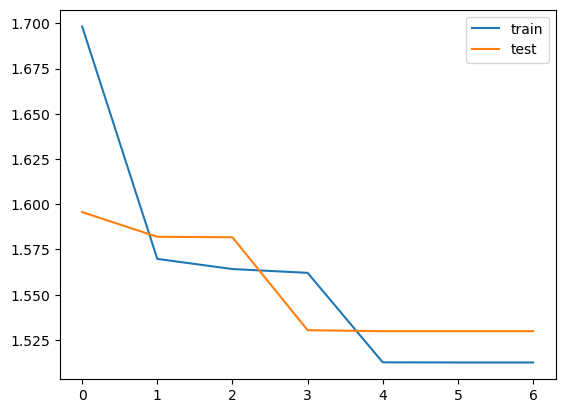

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('rkv_LSTM_loss and val_loss.png')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
reloaded_model = load_model('saved_models/rkv_LSTM_model_att_augm')

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs_1, state_h1, state_c1])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_hidden_state_input = Input(shape=(max_text_length,hidden_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs3] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['<BOS>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<EOS>'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == '<EOS>'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['bos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2transcript(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
orig_dataset = pd.read_csv('mtsamples.csv')
orig_dataset.drop("Unnamed: 0", axis = 1, inplace=True)
orig_dataset.drop("keywords", axis = 1, inplace=True)
orig_dataset.drop_duplicates()
orig_dataset.dropna(axis = 0, inplace = True)

In [ ]:
from datasets import load_metric
import csv

metric = load_metric("rouge")
data1 = pd.read_csv("mtsamples.csv") 

transcriptions = []
actual_summaries = []
predicted_summaries = []

transcriptions.append('transcription')
actual_summaries.append('actual_summaries')
predicted_summaries.append('predicted_summaries')

for i in range(len(orig_dataset['description'])):
    transcription_data = data1['transcription'][i]
    transcriptions.append(data1['transcription'][i])
    predicted_summaries.append(seq2summary(y_train_final[i]))
    
    actual_summaries.append(data1['description'][i])

rows = zip(transcriptions, actual_summaries, predicted_summaries)

with open('mtsamples_output.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

metric.compute(predictions=predicted_summaries, references=actual_summaries)

# for i in range(len(y_tr)):
#     print(seq2summary(y_tr[i]))

{'rouge1': AggregateScore(low=Score(precision=0.021559886883868864, recall=0.01633466842562749, fmeasure=0.015974664151131333), mid=Score(precision=0.023151126759101713, recall=0.017605552315619544, fmeasure=0.01710914888689647), high=Score(precision=0.024829320015158647, recall=0.018972124276443268, fmeasure=0.018344531577608538)),
 'rouge2': AggregateScore(low=Score(precision=0.001598316756606142, recall=0.0010652374416032283, fmeasure=0.0011563403941198533), mid=Score(precision=0.0021037102439026905, recall=0.0014539096337942879, fmeasure=0.001540982546905058), high=Score(precision=0.0027997024010090613, recall=0.00197302655562792, fmeasure=0.0021027902527140396)),
 'rougeL': AggregateScore(low=Score(precision=0.020767114518533174, recall=0.015628856488553222, fmeasure=0.015267398048660792), mid=Score(precision=0.02228636405049833, recall=0.016939194308527868, fmeasure=0.01642506941784002), high=Score(precision=0.023916024947271904, recall=0.018225775185674416, fmeasure=0.0176425724

In [ ]:
print("original : ", actual_summaries[3])
print("predicted : ", predicted_summaries[3])

original :   Consult for laparoscopic gastric bypass.
predicted :  shortness breath two weeks history pneumonia ct angiography chest contrast axial ct images chest obtained pulmonary embolism protocol utilizing 100 ml isovue 300 


In [ ]:
print("original : ", actual_summaries[5])
print("predicted : ", predicted_summaries[5])

# **Model 3 : Fine Tuning T5-small model with our medical dataset**
**We** **fine tuned the Tt5-small model using tensorflow with help of hugging face and could be able transfer learn and train it successfully. Here is the article that we reffered to fine tuned the t5 model with our dataset,** https://huggingface.co/docs/transformers/training 

**Login to Hugging Face Hub**
As we are going to upload our model on the hugging face website, so that everyone can see it and use our model to get summaries of medical reports. Even now, you can go to this link https://huggingface.co/Mohan515/t5-small-finetuned-medical to view our t5-small model.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


**Logging** **to github through hugging face to upload our models and using** **GITHUB** 

In [ ]:
! apt install git-lfs
! git config --global user.email "dharmavarapumohanteja1997@gmail.com"
! git config --global user.name "Mohan Teja Dharmavarapu"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


**Importing transformers library**

In [ ]:
import transformers

print(transformers.__version__)

4.24.0


**Loading pretrained T5 small model as a checkpoint**

In [ ]:
model_checkpoint = "t5-small"

**Loading our custom pre processed dataset that we did in the start of the notebook, here we used popular medical dataset mtsamples.csv which is located in our google drive which we are going to use for fine tuning**

In [ ]:
import pandas as pd 
    
data1 = pd.read_csv("pre_procesed_mtsamples.csv") 
#data1['keywords']+' '+data1['transcription']
data = data1.drop(columns=['Unnamed: 0', 'sample_name'])
data.head()

,transcription,description
0,prescription written well. used last summer be...,23-year-old white female presents complaint al...
1,difficulty snoring. afebrile. likes chicken st...,consult laparoscopic gastric bypass.
2,"denies cellulitis, pseudotumor cerebri, mening...",consult laparoscopic gastric bypass.
3,"normal size right left ventricle.,3. pericardi...",2-d m-mode. doppler.
4,"estimated right atrial pressure 10 mmhg.,8. es...",2-d echocardiogram


**Dropping all NA values in the dataset to makesure that we dont have any NA values**

In [ ]:
data.dropna(axis=0,inplace=True)
data.rename(columns={'description': 'summary'}, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19840 entries, 0 to 19863
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transcription  19840 non-null  object
 1   summary        19840 non-null  object
dtypes: object(2)
memory usage: 465.0+ KB


In [ ]:
import numpy as np

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.head()

,transcription,summary
0,used last summer began using two weeks ago. tm...,23-year-old white female presents complaint al...
1,smoked significantly several months ago. curre...,consult laparoscopic gastric bypass.
2,"history present illness: , seen abc today. los...",consult laparoscopic gastric bypass.
3,"pericardial effusion.,6. normal morphology aor...",2-d m-mode. doppler.
4,"pericardial effusion intracardiac mass seen.,1...",2-d echocardiogram


In [ ]:
data.to_csv('mtsamples_preprocessed', sep=',')

**Loading rouge metric library to caluclate rouge1, rouge2, rougeL for the t5-small model that we are fine tuning with medical dataste and divide the dataset into train, test validation datasets**

In [ ]:
from datasets import load_dataset, load_metric, DatasetDict


rd = load_dataset('csv', data_files=['mtsamples_preprocessed'], split='train')

rd_split = rd.train_test_split(shuffle = True, seed = 200, test_size=0.1)

rd_test = rd_split['test'].train_test_split(shuffle = True, seed = 200, test_size=0.50)

rd_final = DatasetDict({
    'train': rd_split['train'],
    'test': rd_test['test'],
    'validate': rd_test['train']})

metric = load_metric("rouge")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-675f0bb4df721fc6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


In [ ]:
rd_final

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'transcription', 'summary'],
        num_rows: 14018
    })
    test: Dataset({
        features: ['Unnamed: 0', 'transcription', 'summary'],
        num_rows: 779
    })
    validate: Dataset({
        features: ['Unnamed: 0', 'transcription', 'summary'],
        num_rows: 779
    })
})

In [ ]:
rd_final["test"][0]

{'Unnamed: 0': 3703,
 'transcription': 'lung heart ratio 0.34. appears moderate size inferoapical perfusion defect moderate degree. indications:, previously markedly abnormal dobutamine myoview stress test gated scan.,procedure done:, resting myoview perfusion scan gated myocardial scan.,myocardial perfusion imaging:, resting myocardial perfusion spect imaging gated scan carried 32.6 mci tc-99m myoview. rest study done compared previous dobutamine myoview stress test done month dd, yyyy. left ventricular systolic function markedly improved much better regional wall motion left ventricular segments compared previous study done month dd, yyyy. gated myocardial scan revealed mild apical distal inferoseptal hypokinesis ejection fraction 55.,conclusions:, study done rest revealed findings consistent inferior non-transmural scar moderate size moderate degree. cannot assess presence reversible perfusion defects stress imaging performed.',
 'summary': 'resting myoview perfusion scan gated myoc

**Function to just printing dataset which we took reference from the hugging face article we mentioned in few cells above**

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML


def diaply_random(dataset, num_to_show=5):
    assert num_to_show <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_to_show):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
diaply_random(rd_final["train"])

,Unnamed: 0,transcription,summary
0,4287,"preoperative diagnoses,1. metastatic carcinoma bladder.,2. bowel obstruction.,postoperative diagnoses,1. metastatic carcinoma bladder.,2. bowel obstruction.,procedure: , port insertion right subclavian vein percutaneously radiological guidance.,procedure detail: ,the patient electively taken operating room obtaining informed consent. time-out process followed. antibiotics given. then, patients right deltopectoral area prepped draped usual fashion. xylocaine 1 infiltrated. right subclavian vein percutaneously cannulated without difficulty. using seldinger technique, catheter part port, single-lumen port, passed introducer x-ray guidance placed junction superior vena cava right atrium.,a pocket fashioned single-lumen drum port connected catheter, trimmed affixed pectoralis fascia couple sutures vicryl. then, fascia closed using subcuticular suture monocryl. drum aspirated irrigated heparinized saline put pocket skin closed. dressing applied including needle port catheter floor could use catheter right away.,the patient tolerated procedure well sent recovery room satisfactory condition. chest x-ray performed showed complications procedure catheter right place.",port insertion right subclavian vein percutaneously radiological guidance. metastatic carcinoma bladder bowel obstruction.
1,3427,"patient good energy level.,allergic/lymph: , history systemic allergy, abnormal lymph nodes swelling.,musculoskeletal: , fractures, motor weakness, arthritis joint pains. history weight loss. heent:, history headaches, migraines, vertigo, syncope, visual loss, tinnitus, sinusitis, sore mouth, hoarseness, swelling goiter.,respiratory: , shortness breath, wheezing, dyspnea, pulmonary disease, tuberculosis past pneumonias.,cardiovascular: , history palpitations, irregular rhythm, chest pain, hypertension, hyperlipidemia, diaphoresis, congestive heart failure, heart catheterization, stress test recent cardiac tests.,gastrointestinal:, history rectal bleeding, appetite change, abdominal pain, hiatal hernia, ulcer, jaundice, change bowel habits liver problems, history inflammatory bowel problems.,genitourinary: , dysuria, hematuria, frequency, incontinence colic.,nervous system: , gait problems, strokes, numbness muscle weakness.,psychiatric: , history emotional lability, depression sleep disturbances.,oncologic:, history cancer, change moles rashes.","normal review systems template. history headaches, migraines, vertigo, syncope, visual loss, tinnitus, sinusitis, sore mouth, hoarseness, swelling goiter."
2,13667,"skin, subcutaneous tissue, muscle within planned approach anesthetized 1 lidocaine.,with fluoroscopy, 25-gauge 3.5-inch spinal needle gently guided groove sap sacrum dorsal ramus l5 lateral superior border posterior sacral foramen lateral branches s1, s2, s3. patient remained awake throughout procedure order interact give feedback. injected medications preservative free. multiple fluoroscopic views used ensure proper needle placement. patient given opportunity ask questions regarding procedure, indications associated risks.,the risk procedure discussed include infection, bleeding, allergic reaction, dural puncture, headache, nerve injuries, spinal cord injury, cardiovascular cns side effects possible vascular entry medications. skin surrounding treatment area cleaned betadine. area covered sterile drapes, leaving small window opening needle placement. patient understood informed consent desired procedure performed.,procedure: ,oxygen saturation vital signs monitored continuously throughout procedure. sterile technique used throughout procedure.,additional details: , repeated left side.,complications: , none.,discussion: ,postprocedure vital signs oximetry stable. procedure: , bilateral l5 dorsal ramus block bilateral s1, s2, s3 lateral branch block.,indication: , sacroiliac joint pain.,informed consent: , risks, benefits alternatives procedure discussed patient. also informed patient potential side 

**printing metric**

In [ ]:
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

**Checking how metric will caluclate the rouge metric**

In [ ]:
preds = ["hello there", "general kenobi"]
labels = ["hello there", "general kenobi"]
metric.compute(predictions=preds, references=labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

**From Transformers module, we are adding AutoEncoder module which will encode or tokenize the data into embeddings**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
tokenizer("Hello, this is a sentence!")

{'input_ids': [8774, 6, 48, 19, 3, 9, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(["Hello, this is a sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 19, 3, 9, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this is a sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 19, 3, 9, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [ ]:
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [ ]:
max_input_length = 1024
max_target_length = 128


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["transcription"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(rd_final["train"][:2])

{'input_ids': [[21603, 10, 804, 18730, 7, 6, 5411, 8030, 9824, 18719, 6, 2637, 442, 50, 1893, 23643, 3, 3964, 226, 18, 35, 18, 63, 1807, 3929, 20720, 5, 3, 6, 4416, 6676, 13177, 5, 3, 6, 5787, 3, 32, 115, 7593, 757, 2085, 3, 9, 102, 29, 15, 9, 6, 3, 75, 16281, 5, 6, 22280, 3979, 10, 3, 6, 50, 1893, 23643, 3, 3964, 226, 18, 35, 18, 63, 1807, 3929, 20720, 5, 6, 25572, 2833, 503, 9251, 10, 3, 6, 8048, 12471, 1201, 18, 1490, 5069, 6, 2569, 1310, 1207, 23, 9, 3929, 1530, 5002, 1058, 307, 11018, 8030, 9824, 18719, 1968, 3, 287, 127, 9824, 2197, 5, 365, 16103, 1068, 1207, 23, 9, 3929, 5002, 6, 5466, 7, 6, 7028, 7, 6, 554, 32, 102, 3, 5700, 11584, 3, 14515, 1293, 1453, 23550, 11924, 757, 1207, 23, 9, 3929, 3730, 5, 3, 6, 4914, 29, 1009, 239, 3730, 433, 11924, 757, 1807, 3929, 20720, 6, 21533, 26, 168, 6, 16599, 2576, 1071, 6, 1622, 1501, 3860, 442, 11480, 124, 5, 132, 6, 3, 26, 208, 17, 813, 6941, 40, 8606, 7, 2925, 769, 1071, 3, 88, 1893, 77, 6, 778, 8325, 26169, 257, 6, 3, 7, 75, 26, 7, 5, 3

**Loading the final dataset which is ready for training**

In [ ]:
tokenized_datasets = rd_final.map(preprocess_function, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

**Load the pretrained model to fine tune it with final pre processed medical dataset**

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


**Set the parameters to train faster and more efficiently**

In [ ]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

name_of_model = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{name_of_model}-finetuned-medical"

In [ ]:
collect_data = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

collect_data_generation = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128)

In [ ]:
tokenized_datasets["train"]

Dataset({
    features: ['Unnamed: 0', 'transcription', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14018
})

In [ ]:
train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collect_data,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validate"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collect_data,
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_datasets["validate"],
    batch_size=8,
    shuffle=False,
    collate_fn=collect_data_generation
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


**set an optimizer, in this case, we used Adam optimizer**

In [ ]:
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


**defining a function to caluclate rouge metric for the model**

In [ ]:
import numpy as np
import nltk


def caluclate_rouge_metric(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Finally, we trained the model and upload it into the hugging face hub. Just like how we upload in Tensorflow hub, we upload model in same way like in hugging face hub.**

In [ ]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from tensorflow.python.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./summarization_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

metric_callback = KerasMetricCallback(
    caluclate_rouge_metric, eval_dataset=generation_dataset, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

model.fit(
    train_dataset, validation_data=validation_dataset, epochs=1, callbacks=callbacks
)

Cloning https://huggingface.co/Mohan515/t5-small-finetuned-medical into local empty directory.


Download file tf_model.h5:   0%|          | 1.81k/357M [00:00<?, ?B/s]

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.xplane.pb:   1%|          | 16.0k/2.…

Download file logs/train/events.out.tfevents.1668503806.a89420691b21.2259.0.v2:   0%|          | 363/2.78M [00…

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.xplane.pb:   0%|          | 3.44k/2.…

Download file logs/train/events.out.tfevents.1668819503.023f4e62e76c.77.0.v2:   0%|          | 1.48k/2.74M [00…

Download file logs/train/events.out.tfevents.1668499122.a89420691b21.80.2.v2:   0%|          | 3.44k/6.06M [00…

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.xplane.pb:   0%|          | 1.77k/2.…

Download file logs/train/events.out.tfevents.1668498577.a89420691b21.80.0.v2:   0%|          | 1.77k/2.74M [00…

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.xplane.pb:   0%|          | 1.00k/2.21M…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.xplane.pb:   0%|          | 3.48k/2.…

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.xplane.pb:   0%|          | 1.00k/2.22M…

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.kernel_stats.pb:   0%|          | 1.…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.kernel_stats.pb:   1%|1         | 3.…

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.kernel_stats.pb:   1%|1         | 3.…

Clean file logs/train/events.out.tfevents.1668503806.a89420691b21.2259.0.v2:   0%|          | 1.00k/2.78M [00:…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.xplane.pb:   0%|          | 1.00k/2.22M…

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.trace.json.gz:   1%|          | 1.77…

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.trace.json.gz:   1%|1         | 3.44…

Clean file logs/train/events.out.tfevents.1668498577.a89420691b21.80.0.v2:   0%|          | 1.00k/2.74M [00:00…

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.trace.json.gz:   1%|          | 1.43…

Clean file logs/train/events.out.tfevents.1668819503.023f4e62e76c.77.0.v2:   0%|          | 1.00k/2.74M [00:00…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.trace.json.gz:   1%|          | 1.74…

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.tensorflow_stats.pb:   2%|1         …

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.tensorflow_stats.pb:   2%|1         …

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.kernel_stats.pb:   0%|          | 1.00k…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.tensorflow_stats.pb:   1%|          …

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.tensorflow_stats.pb:   2%|1         …

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.memory_profile.json.gz:   3%|2      …

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.memory_profile.json.gz:   5%|5      …

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.memory_profile.json.gz:   4%|4      …

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.kernel_stats.pb:   1%|1         | 3.…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.memory_profile.json.gz:   1%|       …

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.kernel_stats.pb:   0%|          | 1.00k…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.overview_page.pb:  62%|######1   | 3…

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.overview_page.pb:  32%|###2      | 1…

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.overview_page.pb:  63%|######3   | 3…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.xplane.pb:   0%|          | 1.00k/2.20M…

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.overview_page.pb:  60%|######    | 3…

Download file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.input_pipeline.pb:  13%|#2        | …

Download file logs/validation/events.out.tfevents.1668499548.a89420691b21.80.3.v2: 100%|##########| 154/154 [0…

Download file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.input_pipeline.pb:  62%|######1   | …

Download file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.input_pipeline.pb: 100%|##########| …

Download file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.input_pipeline.pb:  60%|######    | …

Download file logs/validation/events.out.tfevents.1668504157.a89420691b21.2259.1.v2: 100%|##########| 154/154 …

Download file logs/validation/events.out.tfevents.1668819853.023f4e62e76c.77.1.v2: 100%|##########| 154/154 [0…

Download file logs/validation/events.out.tfevents.1668499021.a89420691b21.80.1.v2: 100%|##########| 108/108 [0…

Download file logs/train/events.out.tfevents.1668498601.a89420691b21.profile-empty: 100%|##########| 40.0/40.0…

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.trace.json.gz:   0%|          | 1.00k/2…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.trace.json.gz:   0%|          | 1.00k/2…

Clean file logs/train/events.out.tfevents.1668499122.a89420691b21.80.2.v2:   0%|          | 1.00k/6.06M [00:00…

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.trace.json.gz:   0%|          | 1.00k/2…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.trace.json.gz:   0%|          | 1.00k/2…

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.tensorflow_stats.pb:   1%|          | 1…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.tensorflow_stats.pb:   1%|          | 1…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.tensorflow_stats.pb:   1%|          | 1…

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.tensorflow_stats.pb:   1%|          | 1…

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.memory_profile.json.gz:   1%|1         …

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.memory_profile.json.gz:   1%|1         …

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.overview_page.pb:  18%|#8        | 1.00…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.overview_page.pb:  18%|#7        | 1.00…

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.overview_page.pb:  18%|#7        | 1.00…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.memory_profile.json.gz:   1%|1         …

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.kernel_stats.pb:   0%|          | 1.00k…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.memory_profile.json.gz:   2%|1         …

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.overview_page.pb:  19%|#8        | 1.00…

Clean file logs/train/plugins/profile/2022_11_19_00_58_47/023f4e62e76c.input_pipeline.pb:  33%|###3      | 1.0…

Clean file logs/validation/events.out.tfevents.1668499548.a89420691b21.80.3.v2: 100%|##########| 154/154 [00:0…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.kernel_stats.pb:   0%|          | 1.00k…

Clean file logs/train/plugins/profile/2022_11_15_07_58_44/a89420691b21.input_pipeline.pb:  34%|###4      | 1.0…

Clean file logs/train/plugins/profile/2022_11_15_07_50_01/a89420691b21.input_pipeline.pb:  34%|###4      | 1.0…

Clean file logs/train/plugins/profile/2022_11_15_09_17_09/a89420691b21.input_pipeline.pb:  33%|###3      | 1.0…

Clean file logs/validation/events.out.tfevents.1668504157.a89420691b21.2259.1.v2: 100%|##########| 154/154 [00…

Clean file logs/validation/events.out.tfevents.1668819853.023f4e62e76c.77.1.v2: 100%|##########| 154/154 [00:0…

Clean file logs/validation/events.out.tfevents.1668499021.a89420691b21.80.1.v2: 100%|##########| 108/108 [00:0…

Clean file logs/train/events.out.tfevents.1668498601.a89420691b21.profile-empty: 100%|##########| 40.0/40.0 [0…

Clean file tf_model.h5:   0%|          | 1.00k/357M [00:00<?, ?B/s]

  6/438 [..............................] - ETA: 6:40 - loss: 1.3942

438/438 [==============================] - ETA: 0s - loss: 0.8018

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  return py_builtins.overload_of(f)(*args)


438/438 [==============================] - 422s 914ms/step - loss: 0.8018 - val_loss: 0.5835 - rouge1: 43.3783 - rouge2: 35.1091 - rougeL: 41.6332 - rougeLsum: 42.5743 - gen_len: 17.4718


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file tf_model.h5:   0%|          | 3.34k/357M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Mohan515/t5-small-finetuned-medical
   f1060e7..61d56be  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Mohan515/t5-small-finetuned-medical
   f1060e7..61d56be  main -> main



**Downloading the model we uploaded into hugging face hub to predict the summaries**

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# You can of course substitute your own username and model here if you've trained and uploaded it!
model_name = 'Mohan515/t5-small-finetuned-medical'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/374M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Mohan515/t5-small-finetuned-medical.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


**Finally, we can see the data can be able to predict summaries and we uploaded appended those original summaries and predicted summaries into a list and printed them**

**We also caluclated rouge metrics which are rouge1, rouge2, rougeL with the predicted summaries and the original summaries and scores can be seen in the resultnt cell below.**

Now, after fine tuning t5-small model

In [ ]:
import csv

data1 = pd.read_csv("pre_procesed_mtsamples.csv") 

transcriptions = []
actual_summaries = []
predicted_summaries = []

transcriptions.append('transcription')
actual_summaries.append('actual_summarie')
predicted_summaries.append('predicted_summarie')

for i in range(10):
  transcription_data = data1['transcription'][i]
  transcriptions.append(data1['transcription'][i])
  if 't5' in model_name: 
      transcription_data = "summarize: " + transcription_data
  tokenized = tokenizer([transcription_data], return_tensors='np')
  out = model.generate(**tokenized, max_length=128)
  with tokenizer.as_target_tokenizer():
    out1 = tokenizer.decode(out[0])
    out1.replace("<pad> ", "")
    out1.replace("</s>", "")
    predicted_summaries.append(out1)
    
    actual_summaries.append(data1['description'][i])

rows = zip(transcriptions, actual_summaries, predicted_summaries)

with open('mtsamples_output', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)


for i in range(len(actual_summaries)):
  print(f'Actual Summary: {actual_summaries[i]}')
  print(f'Predicted Summary: {predicted_summaries[i]}')
  print('')

metric.compute(predictions=predicted_summaries, references=actual_summaries)

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


Actual Summary: actual_summarie
Predicted Summary: predicted_summarie

Actual Summary: 23-year-old white female presents complaint allergies.
Predicted Summary: <pad> used last summer began using two weeks ago. tms clear. supple without adenopathy.</s>

Actual Summary: consult laparoscopic gastric bypass.
Predicted Summary: <pad> smoked significantly several months ago. currently weighs 312 pounds. gastroesophageal reflux disease.</s>

Actual Summary: consult laparoscopic gastric bypass.
Predicted Summary: <pad> 184 pounds overweight. need go dr. xyz previously sleep study. smokes one half pack day 15 years, recently stopped smoking past two weeks.</s>

Actual Summary: 2-d m-mode. doppler.
Predicted Summary: <pad> mild mitral tricuspid regurgitation. trace aortic pulmonary regurgitation.</s>

Actual Summary: 2-d echocardiogram
Predicted Summary: <pad> mitral annular calcification extending leaflets supportive structures thickening mitral valve leaflets mild mitral regurgitation.</s>

A

{'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.13636363636363635, fmeasure=0.13636363636363635)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.13636363636363635, fmeasure=0.13636363636363635)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.136363636363636

**We are getting good summaries with fine tunning for t5-small model, although, they are not exactlly simillar to the original summaries that are written by human but contextually almost simillar.**

# **Model 4: BERT MODEL FINE TUNED WITH OUR MEDICAL TRANSCRIPT DATASET**

In [ ]:
import pandas as pd
data=pd.read_csv("mtsamples_preprocessed.csv")
import torch
data

,Unnamed: 0,Unnamed: 0.1,summary,transcription
0,0,0,a 23-year-old white female presents with comp...,"subjective:, this 23-year-old white female pr..."
1,1,1,consult for laparoscopic gastric bypass.,"past medical history:, he has difficulty climb..."
2,2,2,consult for laparoscopic gastric bypass.,"history of present illness: , i have seen abc ..."
3,3,3,2-d m-mode. doppler.,"2-d m-mode: , ,1. left atrial enlargement wit..."
4,4,4,2-d echocardiogram,1. the left ventricular cavity size and wall ...
...,...,...,...,...
3893,3893,4984,patient suffered from morbid obesity for many...,"admission diagnosis:, morbid obesity. bmi is..."
3894,3894,4985,patient presented to the bariatric surgery se...,"history of present illness:, ms. a is a 55-ye..."
3895,3895,4989,evaluation for elective surgical weight loss ...,"past medical history: ,she had a negative str..."
3896,3896,4993,"chronic glossitis, xerostomia, probable envir...","history:, a 55-year-old female presents self-..."


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.4 MB/s 
     |████████████████████████████████| 115 kB 43.0 MB/s 
     |████████████████████████████████| 212 kB 41.4 MB/s 
     |████████████████████████████████| 127 kB 47.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 38.1 MB/s 
     |████████████████████████████████| 182 kB 31.8 MB/s 


In [ ]:
import torch
from transformers import BartTokenizer,BartForConditionalGeneration,Trainer, TrainingArguments

class BartDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])  # len(self.labels)

def build_data(model, 
                 tr_texts, tr_labels, 
                 val_texts=None, val_labels=None, 
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = BartTokenizer.from_pretrained(model)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def data_tokenize(texts, labels):
    encoding = tokenizer(texts, truncation=True, padding=True)
    decoding = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = BartDataset(encoding, decoding)
    return dataset_tokenized

  tr_dataset = data_tokenize(tr_texts, tr_labels)
  val_dataset = data_tokenize(val_texts, val_labels) if prepare_val else None
  test_dataset = data_tokenize(test_texts, test_labels) if prepare_test else None

  return tr_dataset, val_dataset, test_dataset, tokenizer


def fine_tune(model_n, tokenizer, tr_dataset, val_dataset=None, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = BartForConditionalGeneration.from_pretrained(model_n).to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=2,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      per_device_eval_batch_size=1,    # batch size for evaluation, can increase if memory allows
      save_steps=500,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=100,                  # number of update steps before evaluation
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset,            # evaluation dataset
      tokenizer=tokenizer
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      num_train_epochs=2,           # total number of training epochs
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      save_steps=500,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      tokenizer=tokenizer
    )

  return trainer

**PREPARING THE DATASET TO FEED TO THE BART MODEL.**

In [ ]:
texts=data['transcription'].values.tolist()

In [ ]:
summaries=data['summary'].values.tolist()

In [ ]:
from sklearn.model_selection import train_test_split
train_texts=texts[:50]
train_summaries=summaries[:50]
train_texts

['subjective:,  this 23-year-old white female presents with complaint of allergies.  she used to have allergies when she lived in seattle but she thinks they are worse here.  in the past, she has tried claritin, and zyrtec.  both worked for short time but then seemed to lose effectiveness.  she has used allegra also.  she used that last summer and she began using it again two weeks ago.  it does not appear to be working very well.  she has used over-the-counter sprays but no prescription nasal sprays.  she does have asthma but doest not require daily medication for this and does not think it is flaring up.,medications: , her only medication currently is ortho tri-cyclen and the allegra.,allergies: , she has no known medicine allergies.,objective:,vitals:  weight was 130 pounds and blood pressure 124/78.,heent:  her throat was mildly erythematous without exudate.  nasal mucosa was erythematous and swollen.  only clear drainage was seen.  tms were clear.,neck:  supple without adenopathy.

In [ ]:
model_name='facebook/bart-large-cnn'
train_dataset,a,b, tokenizer = build_data(model_name,train_texts,train_summaries)
#trainer = fine_tune(model_name,tokenizer,train_dataset)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [ ]:
trainer = fine_tune(model_name,tokenizer,train_dataset)

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

**TRAININ THE BART MODEL ON CUSTOM MEDICAL TRANSCRIPT DATASET**

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 50
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 406290432


Step,Training Loss
10,8.667000
20,5.952300
30,6.782900
40,5.947400
50,5.127100
60,3.519700
70,2.297200
80,1.758400


Step,Training Loss
10,8.667000
20,5.952300
30,6.782900
40,5.947400
50,5.127100
60,3.519700
70,2.297200
80,1.758400
90,1.334900
100,0.685900




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=100, training_loss=4.20726713180542, metrics={'train_runtime': 3152.2369, 'train_samples_per_second': 0.032, 'train_steps_per_second': 0.032, 'total_flos': 216710460211200.0, 'train_loss': 4.20726713180542, 'epoch': 2.0})

In [ ]:
pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=7dcfdc2008331e1a293a0e924c65040fe3dd534d723539738c5f9b3d0314cd63
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
from datasets import load_metric
#data_dict={'text':texts[50:100],'summary':summaries[50:100]}
rouge_metric=load_metric('rouge')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
model=trainer.model

**COMPUTING ROUGE SCORES FOR THE FINE TUNED BART MODEL**

In [ ]:
predicted_summaries=[]
actual_summaries=[]
for i in range(100,110):
  ARTICLE_SUMMARIZE=data['transcription'][i]
  inputs=tokenizer([ARTICLE_SUMMARIZE],return_tensors='pt')
  summary_ids=model.generate(inputs['input_ids'],min_length=10,max_length=30,early_stopping=False)
  predict_summary=[tokenizer.decode(g,skip_special_tokens=True) for g in summary_ids]
  predicted_summaries.append(predict_summary)
  actual_summaries.append(data['summary'][i])

In [ ]:
rouge_metric.compute(predictions=predicted_summaries,references=actual_summaries)

{'rouge1': AggregateScore(low=Score(precision=0.3583538510101011, recall=0.3639794685990339, fmeasure=0.35053312782567203), mid=Score(precision=0.6117623348873349, recall=0.6187922705314008, fmeasure=0.589281586479254), high=Score(precision=0.8607708333333333, recall=0.8733611111111111, fmeasure=0.8190007922360862)),
 'rouge2': AggregateScore(low=Score(precision=0.31876610644257725, recall=0.30903366370471635, fmeasure=0.29147516025641024), mid=Score(precision=0.5646078431372549, recall=0.5855444091512203, fmeasure=0.54925), high=Score(precision=0.8011204481792717, recall=0.8336134453781512, fmeasure=0.7783657051282051)),
 'rougeL': AggregateScore(low=Score(precision=0.33623079351204355, recall=0.3481473429951692, fmeasure=0.3324083610826333), mid=Score(precision=0.5726272338772338, recall=0.585886287625418, fmeasure=0.5530243269772126), high=Score(precision=0.7964782196969697, recall=0.821138888888889, fmeasure=0.7701693404634581)),
 'rougeLsum': AggregateScore(low=Score(precision=0.3

# **We also used pretrained BART, T5-base and PEGASUS models to evaluate the summaries and their rouge scores to compare with the models that we build from scratch using LSTM, GRU along with fine tuned t5-small and bart models.**

**We took reference from article https://huggingface.co/docs/transformers/main_classes/pipelines to implement summarization using BART, T5-base and pegasus.**
**We also did some research on how those models work from their official paper, here are the their official paper,**
**BART - https://arxiv.org/pdf/1910.13461.pdf** 
**T5-base - https://arxiv.org/pdf/1910.10683.pdf **
**Pegasus - https://arxiv.org/pdf/1912.08777.pdf** 

**Starting with pre processing the data, we imported medical dataset and converted them to pandas and dropped unwanted columns.**

In [ ]:
import pandas as pd 
    
data1 = pd.read_csv("pre_procesed_mtsamples.csv") 
data1['keywords']+' '+data1['transcription']
data = data1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'sample_name', 'keywords'])
data.head()

,transcription,description
0,used last summer began using two weeks ago. tm...,23-year-old white female presents complaint al...
1,smoked significantly several months ago. curre...,consult laparoscopic gastric bypass.
2,"history present illness: , seen abc today. los...",consult laparoscopic gastric bypass.
3,"pericardial effusion.,6. normal morphology aor...",2-d m-mode. doppler.
4,"pericardial effusion intracardiac mass seen.,1...",2-d echocardiogram


**Here, like we did during fine tuning with t5, we dropped NA values with rest of the pre processing steps just to make sure that no NA values present**

In [ ]:
data.dropna(axis=0,inplace=True)
data.rename(columns={'description': 'summary'}, inplace=True)

In [ ]:
import numpy as np

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.to_csv('mtsamples_preprocessed', sep=',')

In [ ]:
data.isna().any() == True

transcription    False
summary          False
dtype: bool

**From the article from hugging face website, we learnt how to download a pretrained model and use it for a specific task with our requirements,** **here is the article,** https://huggingface.co/docs/transformers/main_classes/pipelines 

In [ ]:
from transformers import pipeline

# bert_summarizer = pipeline("summarization", model = "bert-base-uncased")
bart_large_summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")
t5_base_summarizer = pipeline("summarization", model= "t5-base")
pegasus_summarizer = pipeline("summarization", model = "google/pegasus-xsum")

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

**From the models we downloaded, we used our dataset to caluclate sumarries using pegasus, bart-large and t5-base model and appended them into a list to caluclate rouge metric**

In [ ]:
transcripts = []
summaries = []
pegasus_predicted = []
bart_large_predicted = []
t5_base_predicted = []

transcripts.append('transcripts')
summaries.append('actual summaries')
pegasus_predicted.append('pegasus summaries')
bart_large_predicted.append('bart large summaries')
t5_base_predicted.append('t5 base summaries')

for i in range(10):
  try:
    # , max_length=20000
    pegasus_summarie = pegasus_summarizer(data['transcription'][i])
    pegasus_predicted.append(pegasus_summarie)

    bart_large_summarie = bart_large_summarizer(data['transcription'][i])
    bart_large_predicted.append(bart_large_summarie)

    t5_base_summarie = t5_base_summarizer(data['transcription'][i])
    t5_base_predicted.append(t5_base_summarie)

    summaries.append(data['summary'][i])
    transcripts.append(data['transcription'][i])
    print(f'{i} tried')
  except IndexError:
    print(f'{i} excepted')
    continue

0 tried


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors


1 tried
2 excepted


Your max_length is set to 142, but you input_length is only 137. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)
Your max_length is set to 200, but you input_length is only 162. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


3 tried
4 tried
5 excepted
6 excepted


Your max_length is set to 142, but you input_length is only 137. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)
Your max_length is set to 200, but you input_length is only 161. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


7 tried
8 tried


Your max_length is set to 142, but you input_length is only 126. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 200, but you input_length is only 144. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


9 tried


**Displayed the summaries generated by pegasus, bart and t5 models, just to get an overview.**

In [ ]:
print(f'summaries of pegasus {pegasus_predicted}')
print(f'summaries of bart {bart_large_predicted}')
print(f'summaries of t5 {t5_base_summarie}')

summaries of pegasus ['pegasus summaries', [{'summary_text': 'nasal sprays known as nasonex.'}], [{'summary_text': 'lynnholmberg greenwich eastchester, new york feels appropriate program.'}], [{'summary_text': 'Key words: aortic valve, tricuspid valve, pulmonary valve.'}], [{'summary_text': 'All images are copyrighted.'}], [{'summary_text': 'All images are copyrighted.'}], [{'summary_text': 'cannula used carry liposuction abdomen removing total 1100 cc aspirate, mostly fat, little fluid, blood.'}], [{'summary_text': 'All images are copyrighted.'}]]
summaries of bart ['bart large summaries', [{'summary_text': '23-year-old white female presents complaint allergies. Used over-the-counter sprays prescription nasal sprays. Used allegra also. used last summer began using two weeks ago. tms clear.,neck: supple without adenopathy.,lungs: clear.,assessment: allergic rhinitis.'}], [{'summary_text': ' lynn holmberg greenwich eastchester, new york feels appropriate program. currently weighs 312 po

In [ ]:
rows = zip(transcripts, summaries, pegasus_predicted, bart_large_predicted, t5_base_summarie)

In [ ]:
import csv

with open('soa_summaries', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

**caluclated the rouge metric for all 3 pre trained models**

In [ ]:
from datasets import load_metric
metric = load_metric("rouge")

rouge_pegasus = metric.compute(predictions=pegasus_predicted, references=summaries)
rouge_bart_large = metric.compute(predictions=bart_large_predicted, references=summaries)
rouge_t5_base = metric.compute(predictions=t5_base_predicted, references=summaries)

**Displaying the rouge score of PEGASUS model**

In [ ]:
print('Pegasus Rouge Metric: ')
rouge_pegasus

Pegasus Rouge Metric: 


{'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.06985294117647059, recall=0.08333333333333333, fmeasure=0.07336956521739131), high=Score(precision=0.1948529411764706, recall=0.20833333333333334, fmeasure=0.1983695652173913)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.06985294117647059, recall=0.08333333333333333, fmeasure=0.07336956521739131), high=Score(precision=0.1948529411764706, recall=0.20833333333333334, fmeasure=0.1983695652173913)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.06985294117647059, recall=0.08333333333333333, fmeasure=0.07336956521739131), high=Score(precision=0.1948529411764706, recall=0.20833333333333334, fmeasure=0

**Displaying the rouge score of BART-large model**

In [ ]:
print('Bart Rouge Metric: ')
rouge_bart_large

Bart Rouge Metric: 


{'rouge1': AggregateScore(low=Score(precision=0.01732456140350877, recall=0.125, fmeasure=0.031068313953488372), mid=Score(precision=0.08563851489188086, recall=0.37083333333333335, fmeasure=0.12644409507989243), high=Score(precision=0.16608131884944918, recall=0.6375, fmeasure=0.23010204081632657)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.03257103257103257, recall=0.21875, fmeasure=0.05633616118769884), high=Score(precision=0.07744282744282745, recall=0.5, fmeasure=0.132423117709438)),
 'rougeL': AggregateScore(low=Score(precision=0.018971848225214194, recall=0.125, fmeasure=0.03345989558614143), mid=Score(precision=0.08434822521419828, recall=0.3666666666666667, fmeasure=0.12486948267679165), high=Score(precision=0.1756578947368421, recall=0.6375, fmeasure=0.23992248062015503)),
 'rougeLsum': AggregateScore(low=Score(precision=0.018965090779273767, recall=0.125, fmeasure=0.03345989558614143), mid=Score(precision=0.0846491228

**Displaying the rouge score of T5-base model**

In [ ]:
print('T5 Rouge Metric: ')
rouge_t5_base

T5 Rouge Metric: 


{'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.046296296296296294, recall=0.08333333333333333, fmeasure=0.05757575757575758), high=Score(precision=0.12962962962962962, recall=0.20833333333333334, fmeasure=0.1575757575757576)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.046296296296296294, recall=0.08333333333333333, fmeasure=0.05757575757575758), high=Score(precision=0.12962962962962962, recall=0.20833333333333334, fmeasure=0.1575757575757576)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.046296296296296294, recall=0.08333333333333333, fmeasure=0.05757575757575758), high=Score(precision=0.12962962962962962, recall=0.20833333333333334, fmea

# **RESULTS AND COMPARISIONS**

**Totally we caluclated summaries and the rouge metrics from 7 models and compared them, they are,**

1. we build 2 models from scratch which by using LSTM one model and GRU one model
2. we did 2 models of transfer learning and fine tuned pre trained models which are t5-small model and bart model
3. We used 3 SoTA pre trained models without any fine tuning just to compare their results with our own models which are BART-large, T5-base and PEGASUS.

**Here are the results explanations and its comparisions**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Comparing the predicted summaries with actual summaries**

**For LSTM model results**

In [ ]:
LSTM_results = pd.read_csv("LSTM_results.csv")

**Here are the actual summaries along with predicted summaries with LSTM model**

In [ ]:
LSTM_results.head()

,transcription,actual_summaries,predicted_summaries
0,"SUBJECTIVE:, This 23-year-old white female pr...",A 23-year-old white female presents with comp...,patient found limitations extension ip joint r...
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Consult for laparoscopic gastric bypass.,mri brain olfactory groove meningioma
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Consult for laparoscopic gastric bypass.,shortness breath two weeks history pneumonia c...
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,benign prostatic hypertrophy urinary retention...
4,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,psychiatric consultation substance abuse


**For T5 model when its fine tuned with our medical dataset, the results output**

In [ ]:
T5_results = pd.read_csv("T5_results.csv")

**The original and predicted summaries with T5 small model when fine tuned with our dataset**

In [ ]:
T5_results.head()

,actual_summarie,predicted_summarie
0,23-year-old white female presents complaint al...,used last summer began using two weeks ago. tm...
1,consult laparoscopic gastric bypass.,smoked significantly several months ago. curre...
2,consult laparoscopic gastric bypass.,184 pounds overweight. need go dr. xyz previou...
3,2-d m-mode. doppler.,mild mitral tricuspid regurgitation. trace aor...
4,2-d echocardiogram,mitral annular calcification extending leaflet...


In [ ]:
colnames = ['transcription', 'actual_summaries', 'predicted_summaries']
GRU_results = pd.read_csv("GRU_results_seen.csv", names = colnames)

**For Seq2Seq GRU model and its predicted summaries were displayed below**

In [ ]:
GRU_results.head()

,transcription,actual_summaries,predicted_summaries
0,"history of present illness: , the patient is a...",a woman with history of coronary artery diseas...,a with with with history of coronary has had a...
1,"general: ,xxx,vital signs: , blood pressure xx...",normal physical exam template. normocephalic. ...,normal physical exam template. normocephalic. ...
2,"diagnoses:,1. disseminated intravascular coagu...",disseminated intravascular coagulation and str...,excisional biopsy of recurrent pneumonia with ...
3,"chief complaint:, this 26 year old male presen...",patient presents for treatment of suspected rh...,patient presents for treatment of suspected rh...
4,"indication: , rectal bleeding, constipation, a...","colonoscopy due to rectal bleeding, constipati...",flexible sigmoidoscopy due to rectal bleeding....


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['bos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2transcript(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**From all the models we have caluclated, we can see that all models are gramatically predicting good summaries. Our of all, LSTM model is giving us meaningfull summary of actual report when compared to GRU, T5**

## **Now Caluclating Rouge Scores**

**GRU results Rouge scores**

In [ ]:
data = GRU_results

metric = load_metric("rouge")
actual_summaries = data["actual_summaries"]
predicted_summaries = data["predicted_summaries"]

metric.compute(predictions=predicted_summaries, references=actual_summaries)

{'rouge1': AggregateScore(low=Score(precision=0.5105298110313122, recall=0.5002650036522353, fmeasure=0.47705185028166663), mid=Score(precision=0.5180703834060898, recall=0.5088532467770832, fmeasure=0.4842583221832651), high=Score(precision=0.5257073727188445, recall=0.5175417599386194, fmeasure=0.4916538911431797)),
 'rouge2': AggregateScore(low=Score(precision=0.3300073587342938, recall=0.33819322299367466, fmeasure=0.3152107256832019), mid=Score(precision=0.3371450021632362, recall=0.3464212113071503, fmeasure=0.322362925108883), high=Score(precision=0.345200604061425, recall=0.3551427006906926, fmeasure=0.32989983821488283)),
 'rougeL': AggregateScore(low=Score(precision=0.476861078598846, recall=0.470921886070409, fmeasure=0.4472038643497285), mid=Score(precision=0.4843619324188648, recall=0.4792727283948294, fmeasure=0.4549268932157976), high=Score(precision=0.4919329912261318, recall=0.4876767662629281, fmeasure=0.4625076503304109)),
 'rougeLsum': AggregateScore(low=Score(preci

**LSTM ROUGE score**

In [ ]:
from datasets import load_metric
import csv

data1 = LSTM_results

metric = load_metric("rouge")
actual_summaries = data1["actual_summaries"]
predicted_summaries = data1["predicted_summaries"]

metric.compute(predictions=predicted_summaries, references=actual_summaries)

/tmp/ipykernel_278/2865020750.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


{'rouge1': AggregateScore(low=Score(precision=0.021498438709694596, recall=0.016219976671148436, fmeasure=0.0158504609146069), mid=Score(precision=0.023156219022377793, recall=0.017539717731176987, fmeasure=0.01704508255205352), high=Score(precision=0.02483581338855466, recall=0.018850317472202647, fmeasure=0.018255009996065486)),
 'rouge2': AggregateScore(low=Score(precision=0.001620957920109692, recall=0.0010634242545878546, fmeasure=0.0011613187171703031), mid=Score(precision=0.0021367509514533135, recall=0.0014630111346578987, fmeasure=0.001551127932022533), high=Score(precision=0.0028131057925523347, recall=0.001963944850695758, fmeasure=0.002106705236936832)),
 'rougeL': AggregateScore(low=Score(precision=0.02057142900183047, recall=0.015577650333312907, fmeasure=0.015228094708358939), mid=Score(precision=0.022186365998050107, recall=0.01681828948355995, fmeasure=0.01631983005788799), high=Score(precision=0.02387634333263667, recall=0.01812753019877513, fmeasure=0.017588854982552

**Rouge Score of T5**

In [ ]:
import csv

data1 = pd.read_csv("pre_procesed_mtsamples.csv") 

transcriptions = []
actual_summaries = []
predicted_summaries = []

transcriptions.append('transcription')
actual_summaries.append('actual_summarie')
predicted_summaries.append('predicted_summarie')

for i in range(10):
  transcription_data = data1['transcription'][i]
  transcriptions.append(data1['transcription'][i])
  if 't5' in model_name: 
      transcription_data = "summarize: " + transcription_data
  tokenized = tokenizer([transcription_data], return_tensors='np')
  out = model.generate(**tokenized, max_length=128)
  with tokenizer.as_target_tokenizer():
    out1 = tokenizer.decode(out[0])
    out1.replace("<pad> ", "")
    out1.replace("</s>", "")
    predicted_summaries.append(out1)
    
    actual_summaries.append(data1['description'][i])

rows = zip(transcriptions, actual_summaries, predicted_summaries)

with open('mtsamples_output', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)


for i in range(len(actual_summaries)):
  print(f'Actual Summary: {actual_summaries[i]}')
  print(f'Predicted Summary: {predicted_summaries[i]}')
  print('')

metric.compute(predictions=predicted_summaries, references=actual_summaries)

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


Actual Summary: actual_summarie
Predicted Summary: predicted_summarie

Actual Summary: 23-year-old white female presents complaint allergies.
Predicted Summary: <pad> used last summer began using two weeks ago. tms clear. supple without adenopathy.</s>

Actual Summary: consult laparoscopic gastric bypass.
Predicted Summary: <pad> smoked significantly several months ago. currently weighs 312 pounds. gastroesophageal reflux disease.</s>

Actual Summary: consult laparoscopic gastric bypass.
Predicted Summary: <pad> 184 pounds overweight. need go dr. xyz previously sleep study. smokes one half pack day 15 years, recently stopped smoking past two weeks.</s>

Actual Summary: 2-d m-mode. doppler.
Predicted Summary: <pad> mild mitral tricuspid regurgitation. trace aortic pulmonary regurgitation.</s>

Actual Summary: 2-d echocardiogram
Predicted Summary: <pad> mitral annular calcification extending leaflets supportive structures thickening mitral valve leaflets mild mitral regurgitation.</s>

A

{'rouge1': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.13636363636363635, fmeasure=0.13636363636363635)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.13636363636363635, fmeasure=0.13636363636363635)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456), high=Score(precision=0.13636363636363635, recall=0.136363636363636

**Rouge Score of BART model**

In [ ]:
rouge_metric.compute(predictions=predicted_summaries,references=actual_summaries)

{'rouge1': AggregateScore(low=Score(precision=0.3583538510101011, recall=0.3639794685990339, fmeasure=0.35053312782567203), mid=Score(precision=0.6117623348873349, recall=0.6187922705314008, fmeasure=0.589281586479254), high=Score(precision=0.8607708333333333, recall=0.8733611111111111, fmeasure=0.8190007922360862)),
 'rouge2': AggregateScore(low=Score(precision=0.31876610644257725, recall=0.30903366370471635, fmeasure=0.29147516025641024), mid=Score(precision=0.5646078431372549, recall=0.5855444091512203, fmeasure=0.54925), high=Score(precision=0.8011204481792717, recall=0.8336134453781512, fmeasure=0.7783657051282051)),
 'rougeL': AggregateScore(low=Score(precision=0.33623079351204355, recall=0.3481473429951692, fmeasure=0.3324083610826333), mid=Score(precision=0.5726272338772338, recall=0.585886287625418, fmeasure=0.5530243269772126), high=Score(precision=0.7964782196969697, recall=0.821138888888889, fmeasure=0.7701693404634581)),
 'rougeLsum': AggregateScore(low=Score(precision=0.3

**From all the ROUGE SCORE of all the 4 models, we used,** 

**For rouge 1, rouge 2 and rouge L**

**Precision, recall, fmeasure is very high in BART and BART performed very good compared to all other followed with GRU which is also good and also giving us gramatically reasonable summaries. **

**T5 model is very, very bad**

